In [1]:
import sys
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

sys.path.insert(1, '../')

from rule_extraction import *

%load_ext autoreload
%autoreload 2
%matplotlib widget

# Load Data from Folders


In [2]:
dataPairs = []

directories = []
for root, dirs, files in os.walk("../../data/data-wsl2-examples-pause/"):
    for name in dirs:
        directories.append(os.path.join(root, name))


for directory in directories:
    print(f"Processing {directory}")

    files = os.listdir(directory)

    # group files by time AutoPas_liveInfoLogger_Rank0_$2024-05-21_14-24-17$
    data_pairs = {}
    for file in files:
        if "tuningData" in file or "liveInfo" in file:
            time = file.split("_")[-1]

            if not time in data_pairs:
                data_pairs[time] = [None, None]

            if "tuningData" in file:
                data_pairs[time][1] = pd.read_csv(
                    os.path.join(directory, file))
            elif "liveInfo" in file:
                data_pairs[time][0] = pd.read_csv(
                    os.path.join(directory, file))

    # check if tuning and liveInfo files are present
    for time, pair in data_pairs.items():
        if pair[0] is None or pair[1] is None:
            print(f"Missing file for {directory} at time {time}")
            continue

    # filter rows where NaN is present

    for time, (liveInfo, tuningData) in data_pairs.items():
        tuning_iterations = tuningData["Iteration"]

        corresponding_liveInfo = liveInfo.loc[liveInfo["Iteration"].isin(
            tuning_iterations)]

        assert len(corresponding_liveInfo) == len(
            tuningData), "Length of liveInfo and tuningData does not match"

        # strip columns
        corresponding_liveInfo.columns = corresponding_liveInfo.columns.str.strip()
        tuningData.columns = tuningData.columns.str.strip()

        # convert tuningData timings into percentages
        maxTime = tuningData["Reduced"].max()
        tuningData.insert(1, "PerformancePercentage", (
            tuningData["Reduced"] / maxTime) * 100)

        # merge container and Data Layout
        tuningData["Container_DataLayout"] = tuningData["Container"] + \
            "_" + tuningData["Data Layout"]

        tuningData.drop(columns=["Container", "Data Layout"], inplace=True)

        dataPairs.append((corresponding_liveInfo, tuningData))

Processing ../../data/data-wsl2-examples-pause/uniform_cube_4
Processing ../../data/data-wsl2-examples-pause/uniform_cube_1
Processing ../../data/data-wsl2-examples-pause/falling_drop
Processing ../../data/data-wsl2-examples-pause/uniform_cube_3
Processing ../../data/data-wsl2-examples-pause/uniform_cube_7
Processing ../../data/data-wsl2-examples-pause/uniform_cube_6
Processing ../../data/data-wsl2-examples-pause/uniform_cube_2
Processing ../../data/data-wsl2-examples-pause/spinodal_decomp_equilibration
Processing ../../data/data-wsl2-examples-pause/exploding_liquid
Processing ../../data/data-wsl2-examples-pause/uniform_cube_5
Processing ../../data/data-wsl2-examples-pause/spinodial_decomp


In [3]:
df = pd.DataFrame()

for batch, (X, y) in enumerate(dataPairs):
    merged = pd.merge(X, y, on="Iteration")
    df = pd.concat([df, merged])

df = df.drop(columns=["Iteration", "Date_x", "Date_y"])
df = df.drop(list(df.filter(regex='sample')), axis=1)
df.shape

(29001, 29)

In [4]:
df.describe()

avgParticlesPerCell        cutoff   domainSizeX   domainSizeY  \
count         29000.000000  29000.000000  29000.000000  29000.000000   
mean              1.055021      2.915793     61.454753     62.161305   
std               1.590832      0.231965     24.337255     23.534889   
min               0.068390      2.000000     15.000000     29.561231   
25%               0.305312      3.000000     50.000000     50.000000   
50%               0.547120      3.000000     50.000000     50.000000   
75%               0.944637      3.000000    100.000000    100.000000   
max               7.061688      3.000000    100.000000    100.000000   

        domainSizeZ  estimatedNumNeighborInteractions   homogeneity  \
count  29000.000000                      2.900000e+04  29000.000000   
mean      60.517003                      1.307572e+05      0.085891   
std       25.101769                      1.920980e+05      0.103664   
min       15.000000                      3.285000e+03      0.003197   
25%       50.000000                      3.356400e+04      0.027972   
50%       50.000000                      8.085200e+04      0.044302   
75%      100.000000                      9.396900e+04      0.082399   
max      100.000000                      1.032785e+06      0.547827   

         maxDensity  maxParticlesPerCell  minParticlesPerCell  ...  \
count  29000.000000         29000.000000              29000.0  ...   
mean       0.525474            20.193586                  0.0  ...   
std        0.331926             7.419007                  0.0  ...   
min        0.016158             3.000000                  0.0  ...   
25%        0.212400            16.000000                  0.0  ...   
50%        0.520800            22.000000                  0.0  ...   
75%        0.688200            24.000000                  0.0  ...   
max        1.879647            51.000000                  0.0  ...   

       particleSizeNeededByFunctor  particlesPerBlurredCellStdDev  \
count                      29000.0                   29000.000000   
mean                          72.0                       0.328572   
std                            0.0                       0.255198   
min                           72.0                       0.024498   
25%                           72.0                       0.215287   
50%                           72.0                       0.299439   
75%                           72.0                       0.349292   
max                           72.0                       2.008868   

       particlesPerCellStdDev  rebuildFrequency          skin  threadCount  \
count            29000.000000      29000.000000  29000.000000      29000.0   
mean                 0.045466         10.281897      1.064259         12.0   
std                  0.060036          1.153284      0.504646          0.0   
min                  0.011771         10.000000      0.200000         12.0   
25%                  0.017843         10.000000      1.000000         12.0   
50%                  0.040432         10.000000      1.000000         12.0   
75%                  0.045114         10.000000      1.000000         12.0   
max                  0.478737         15.000000      3.000000         12.0   

       PerformancePercentage  CellSizeFactor       Reduced      Smoothed  
count           28996.000000         28998.0  2.899600e+04  2.899500e+04  
mean               17.614161             1.0  5.152603e+07  4.810560e+07  
std                12.772500             0.0  1.008821e+08  8.905544e+07  
min                 1.244363             1.0  6.842310e+05  6.842310e+05  
25%                 9.047081             1.0  1.546688e+07  1.485115e+07  
50%                13.985732             1.0  2.562834e+07  2.468236e+07  
75%                22.416753             1.0  4.520055e+07  4.347496e+07  
max               100.000000             1.0  2.168150e+09  1.934718e+09  

[8 rows x 25 columns]

In [5]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'PerformancePercentage', 'CellSizeFactor', 'Traversal',
       'Load Estimator', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

# Define Interesting Data to observe


In [6]:
inputs = [
    "avgParticlesPerCell",
    # "cutoff",
    # "domainSizeX",
    # "domainSizeY",
    # "domainSizeZ",
    # "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    "maxParticlesPerCell",
    # "minParticlesPerCell",
    # "numCells",
    # "numEmptyCells",
    # "numHaloParticles",
    # "numParticles",
    # "particleSize",
    # "particleSizeNeededByFunctor",
    # "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    # "rebuildFrequency",
    # "skin",
    "threadCount",
]

outputs = [
    "Container_DataLayout",
    # "CellSizeFactor",
    "Traversal",
    # "Load Estimator",
    "Newton 3",
]

In [7]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'PerformancePercentage', 'CellSizeFactor', 'Traversal',
       'Load Estimator', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

# Filter Data / Outliers


In [8]:
# only keep rows where performance percentage is above x
dffiltered = df[df["PerformancePercentage"] >= 70]


def combine_columns(row):
    return ", ".join(sorted(map(str, list(np.unique(row)))))


# group data on input columns and concatenate output columns
dfgrouped = dffiltered.groupby(inputs).agg(combine_columns).reset_index()

# remove columns that are not needed
dfgrouped.drop(columns=["Reduced", "Smoothed",
               "PerformancePercentage"], inplace=True)


# Remove any rows where a numerical colum lies outside 3 standard deviations

X, y =dfgrouped[inputs], dfgrouped[outputs]

print(X.shape, y.shape)

(100, 6) (100, 3)


# Create Train and Test Data


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# save to csv
pd.concat([X_train, y_train], axis=1).to_pickle("train.pkl")
pd.concat([X_test, y_test], axis=1).to_pickle("test.pkl")

# Final Data


In [10]:
pd.concat([X_train, y_train], axis=1).head()

avgParticlesPerCell  homogeneity  maxDensity  maxParticlesPerCell  \
55             0.944637     0.082461    0.684480                 23.0   
88             2.305438     0.086579    0.573123                 11.0   
26             0.944637     0.081545    0.688200                 23.0   
42             0.944637     0.082044    0.706800                 24.0   
69             0.944637     0.082888    0.662160                 21.0   

    particlesPerCellStdDev  threadCount  \
55                0.040583         12.0   
88                0.013639         12.0   
26                0.039974         12.0   
42                0.040130         12.0   
69                0.040563         12.0   

                               Container_DataLayout  \
55          LinkedCells_AoS, VerletClusterLists_AoS   
88  PairwiseVerletLists_SoA, VerletClusterLists_AoS   
26          LinkedCells_AoS, VerletClusterLists_AoS   
42          LinkedCells_AoS, VerletClusterLists_AoS   
69          LinkedCells_AoS, VerletClusterLists_AoS   

                                            Traversal  Newton 3  
55                                    lc_c04, vcl_c06  disabled  
88  vcl_sliced, vcl_sliced_c02, vlp_c08, vlp_c18, ...  disabled  
26                                    lc_c04, vcl_c06  disabled  
42                                    lc_c04, vcl_c06  disabled  
69                                    lc_c04, vcl_c06  disabled

In [11]:
for i, col in enumerate(y.columns):

    y_count = y[col].value_counts()

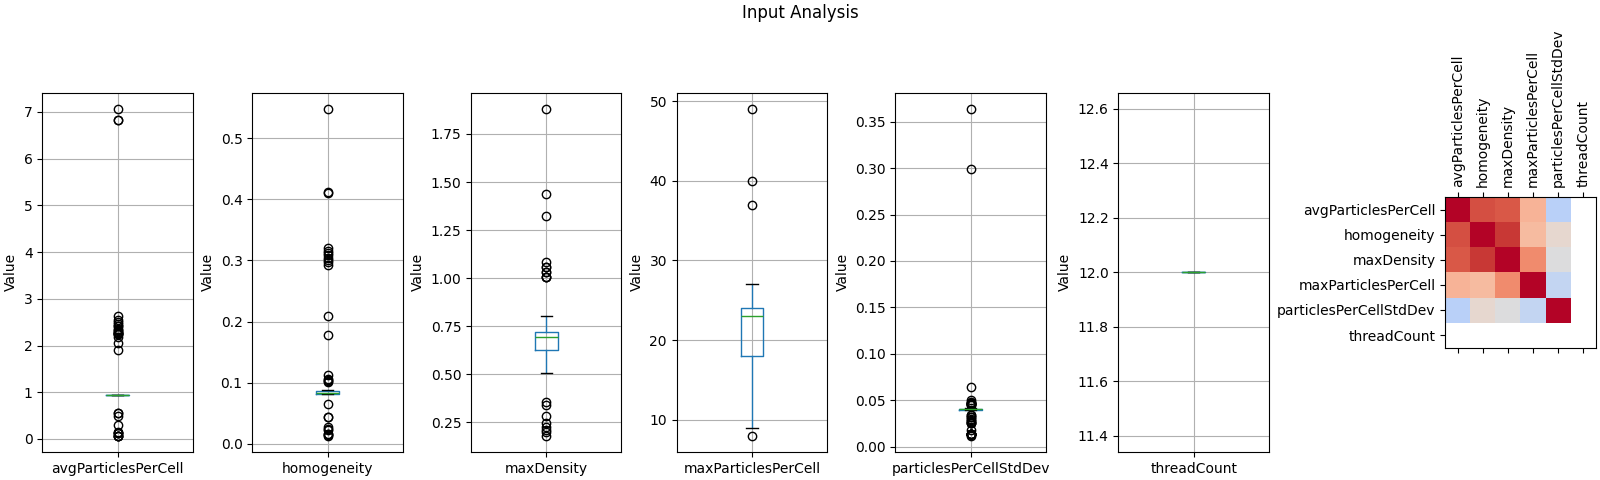

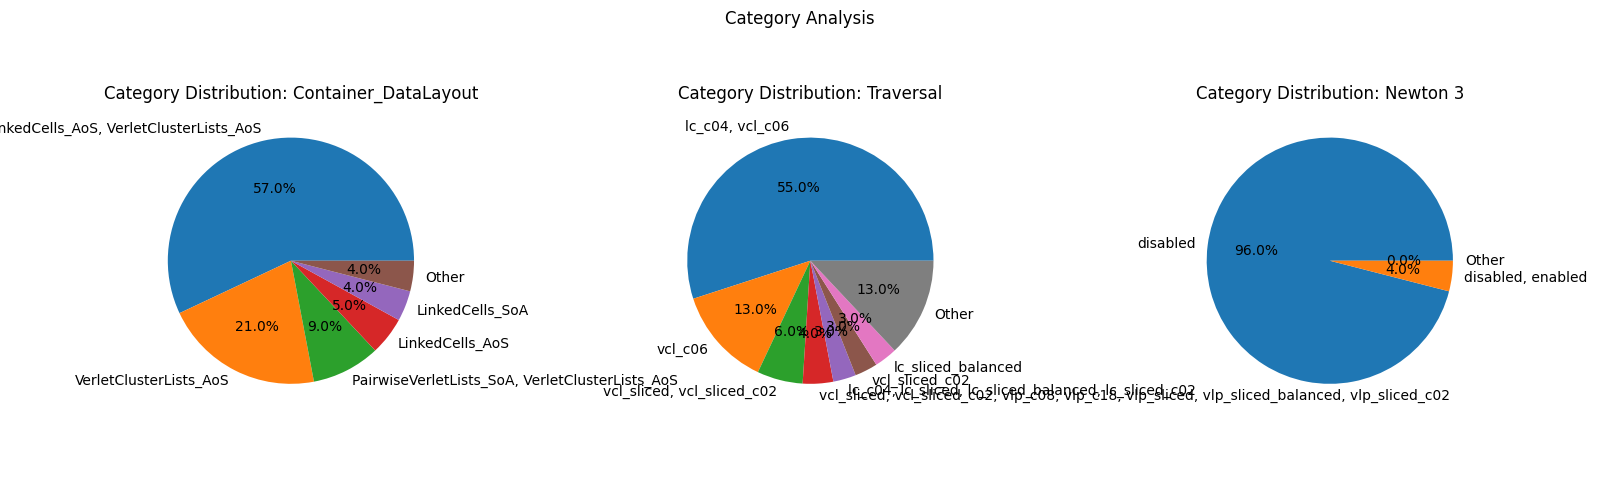

In [12]:
import seaborn as sns

# Row 1
fig, ax1 = plt.subplots(1, len(X.columns)+1, constrained_layout=True)

fig.suptitle("Input Analysis")
fig.set_figwidth(16)

for i, col in enumerate(X.columns):
    X[[col]].boxplot(ax=ax1[i], showfliers=True)
    ax1[i].set_ylabel("Value")

i += 1
# Correlation Matrix
corr = X.corr()
cax = ax1[i].matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
ax1[i].set_xticks(range(len(X.columns)))
ax1[i].set_yticks(range(len(X.columns)))
ax1[i].set_xticklabels(X.columns, rotation=90)
ax1[i].set_yticklabels(X.columns)


# Row 2
fig, ax1 = plt.subplots(1, len(y_train.columns))
fig.suptitle("Category Analysis")
fig.set_figwidth(16)
fig.tight_layout(pad=3.0)


for i, col in enumerate(y.columns):
    y_count = y[col].value_counts()

    total = y_count.sum()

    # grouping categories with less than 2% of the total
    y_count_group = y_count[y_count.gt(total*0.02)]
    y_count_group["Other"] = y_count[~y_count.index.isin(
        y_count_group.index)].sum()

    ax1[i].pie(y_count_group, labels=y_count_group.index, autopct='%1.1f%%')
    ax1[i].set_title(f"Category Distribution: {col}")

# Train Decision Tree and Extract Rules


In [13]:
# number of input parameters that can be used simultaneously
POSSIBLE_NUMBER_OF_COMBINATIONS = [2, 3, 4, 5]

CCP_ALPHA = {
    "Container_DataLayout": 0.05,
    "Traversal": 0.05,
    "Newton 3": 0.05,

}

# maximum depth of the decision tree
MAX_DEPTH = 5

# how many trees should be used to create rules for each label
TOP_K_MODELS_PER_LABEL = 2

Training on 80 samples
Number of rules 68:
	Container_DataLayout (24 rules)
	Traversal (33 rules)
	Newton 3 (11 rules)


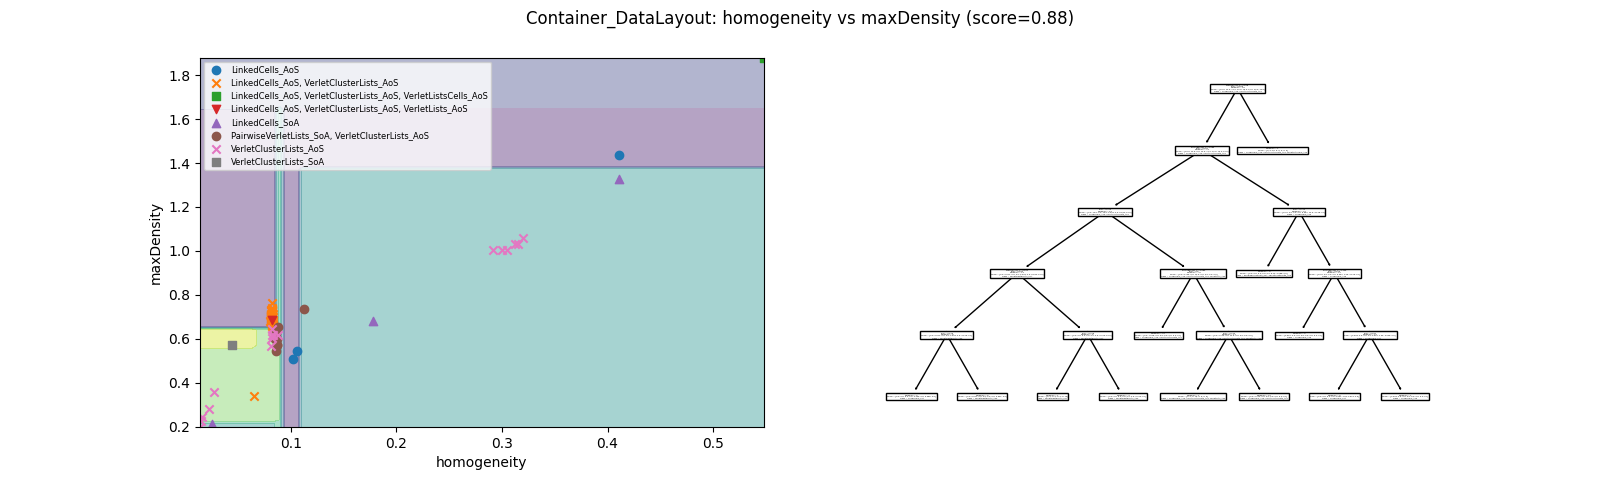

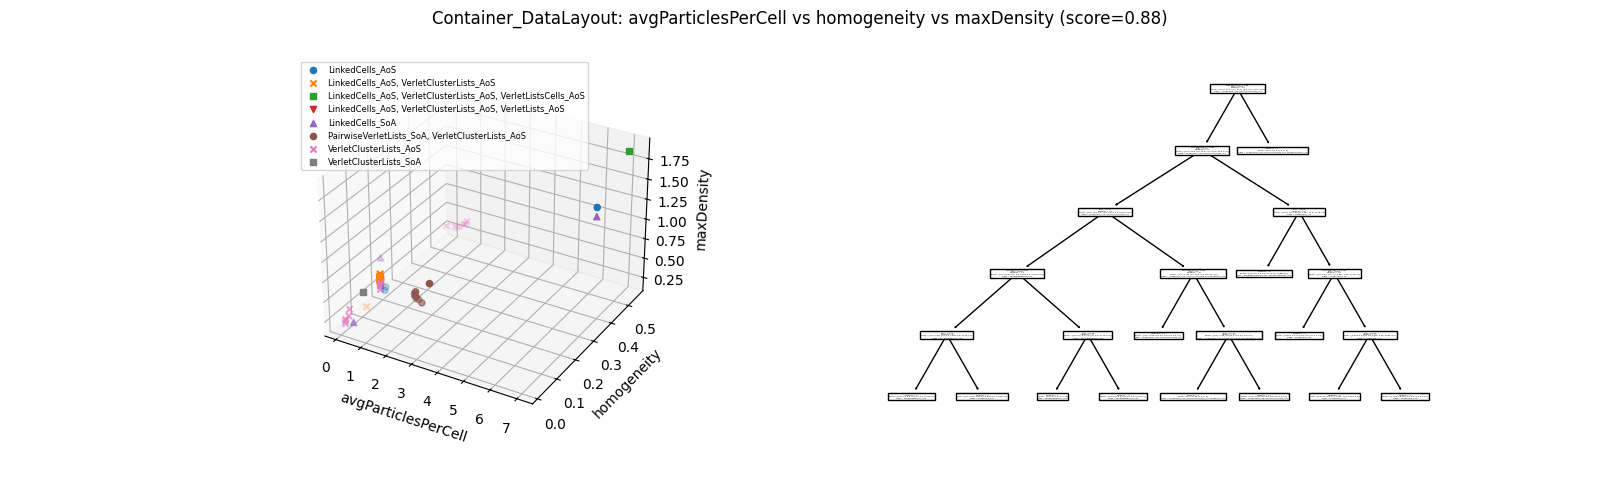

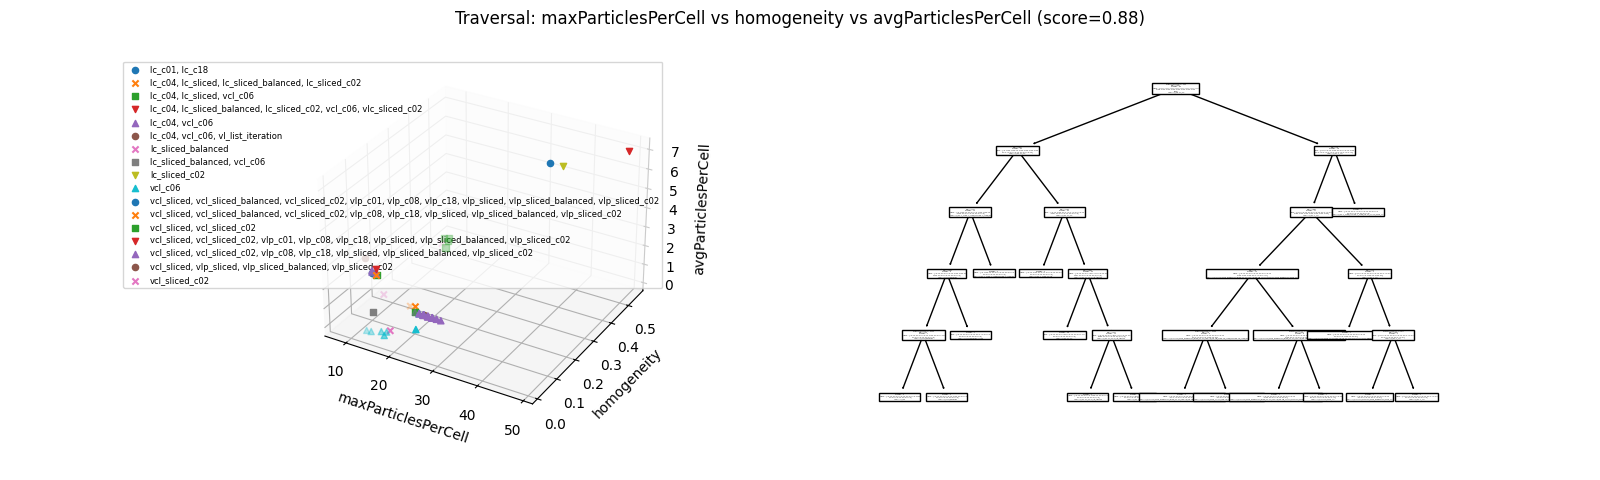

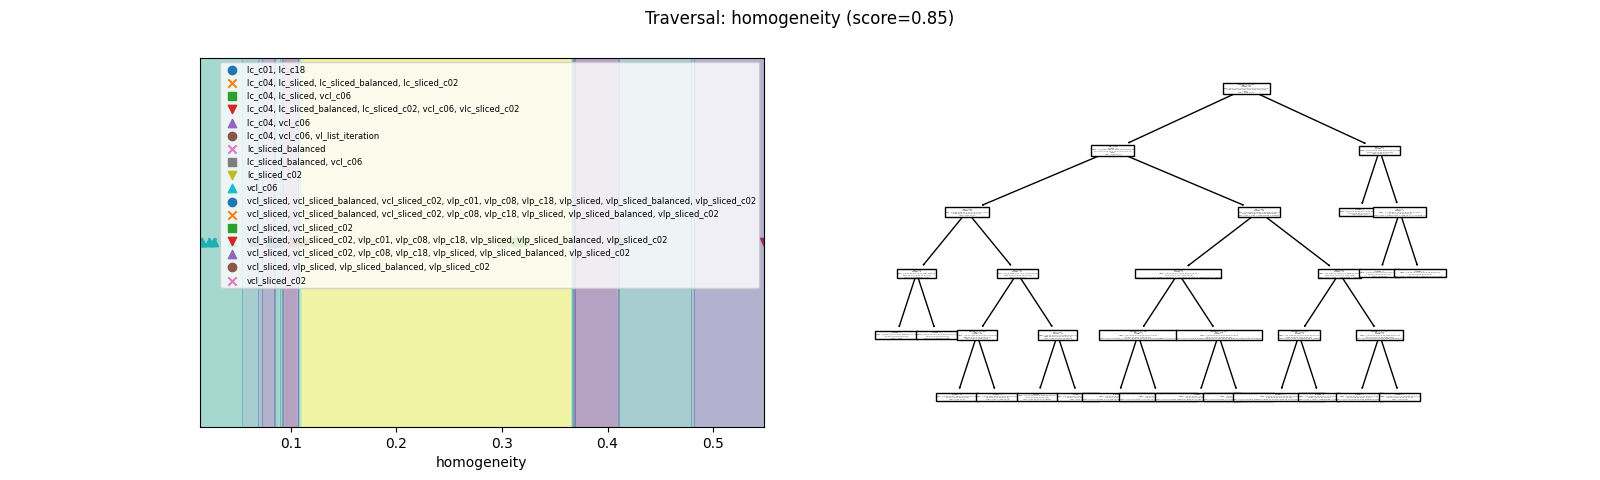

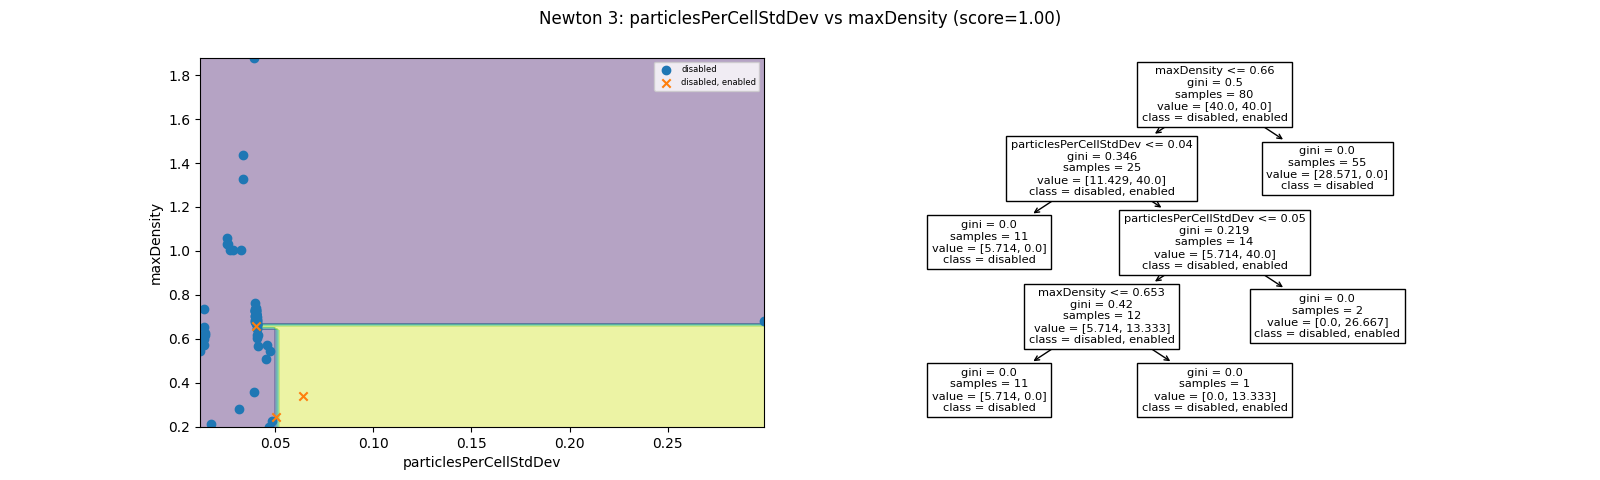

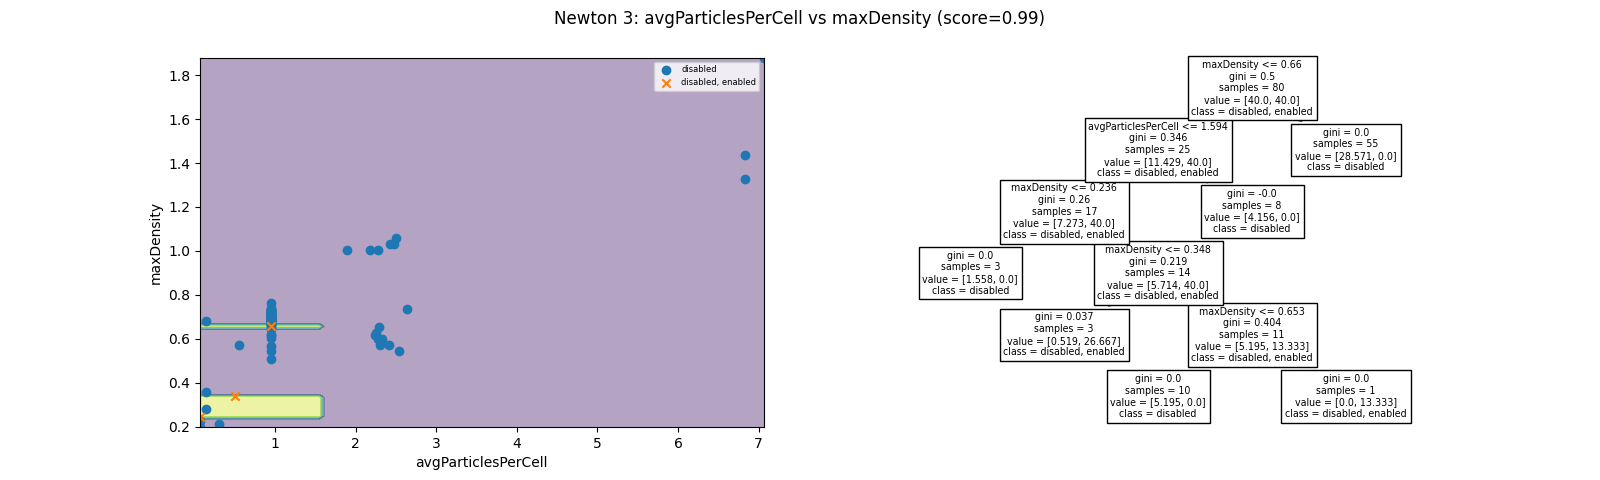

In [14]:
auto_rules = create_auto_rules(X_train, y_train,  None,
                               POSSIBLE_NUMBER_OF_COMBINATIONS, CCP_ALPHA, MAX_DEPTH, TOP_K_MODELS_PER_LABEL)

maxDensity: [-inf, 0.218, 0.236, 0.348, 0.571, 0.588, 0.645, 0.653, 0.66, 1.381, 1.658, inf]
maxDensity: [-inf, 0.218, 0.348, 0.571, 0.645, 1.381, 1.658, inf]

homogeneity: [-inf, 0.055, 0.063, 0.073, 0.083, 0.085, 0.086, 0.087, 0.095, 0.109, 0.145, 0.365, 0.411, 0.48, inf]
homogeneity: [-inf, 0.055, 0.063, 0.073, 0.083, 0.095, 0.109, 0.145, 0.365, 0.411, 0.48, inf]

avgParticlesPerCell: [-inf, 0.142, 0.221, 0.403, 0.723, 1.42, 1.594, 2.266, 2.521, 2.587, 6.944, inf]
avgParticlesPerCell: [-inf, 0.142, 0.403, 0.723, 1.42, 1.594, 2.266, 2.521, 6.944, inf]

maxParticlesPerCell: [-inf, 11.5, 20.5, 21.5, 22.5, inf]
maxParticlesPerCell: [-inf, 11.5, 20.5, 21.5, 22.5, inf]

particlesPerCellStdDev: [-inf, 0.04, 0.05, inf]
particlesPerCellStdDev: [-inf, 0.04, 0.05, inf]



/home/manuel/AutoPas-FuzzyTuning-Bachelor-Thesis/data-analysis/../demo/fuzzy-test/python/fuzzy_system.py:409: RuntimeWarning: overflow encountered in exp
  def function(x): return 1 / (1 + np.exp(-width * (x - center)))


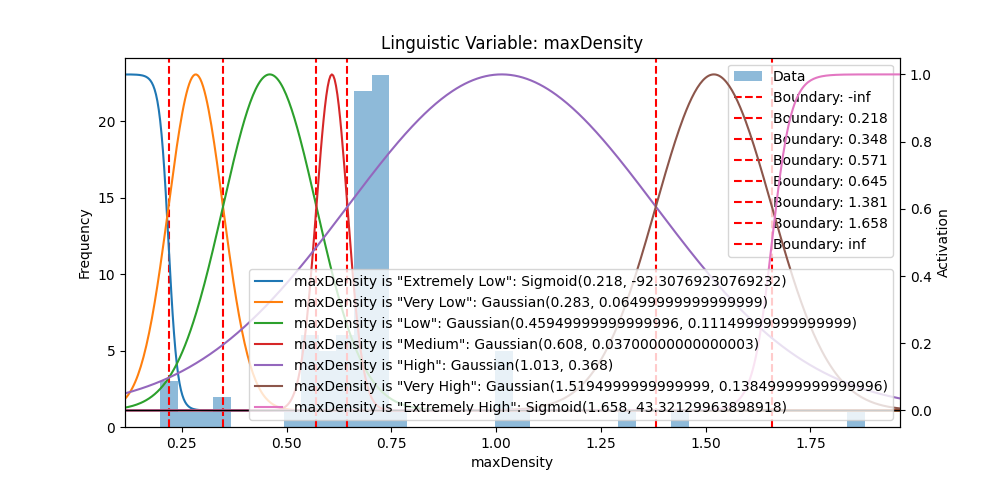

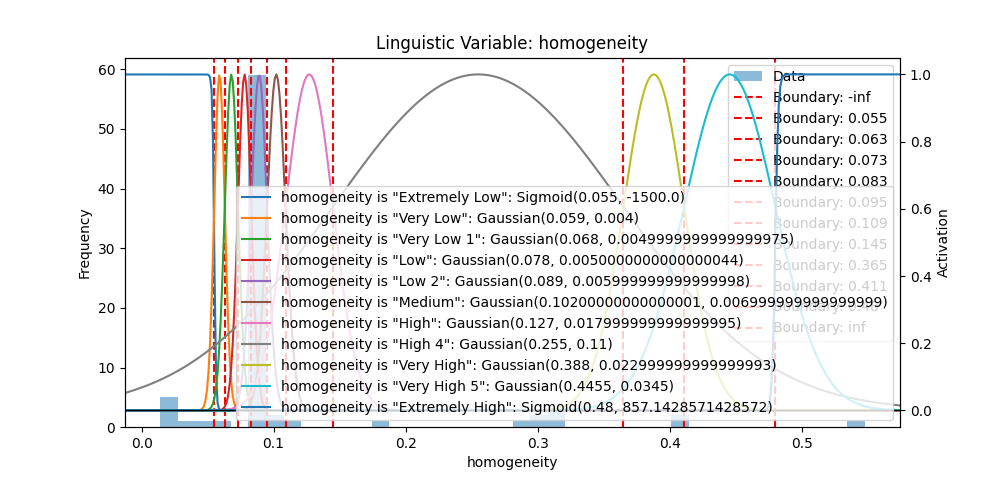

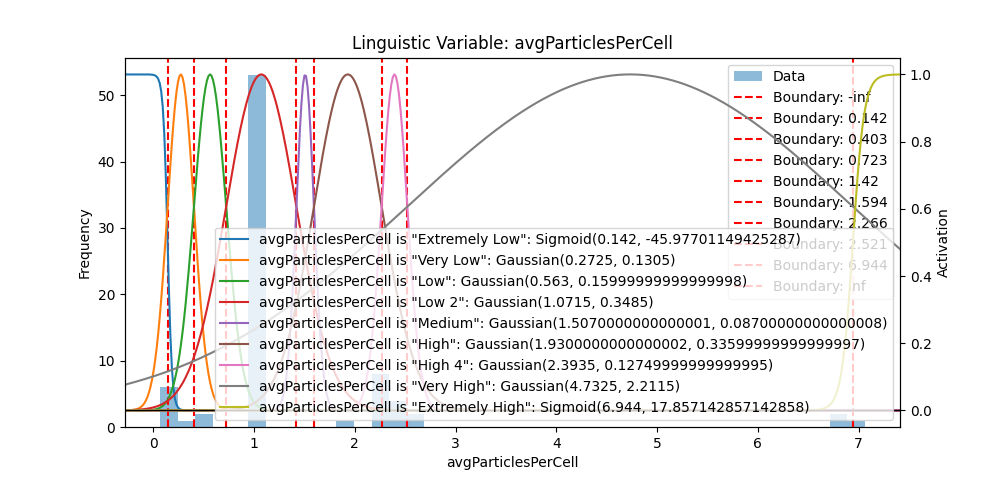

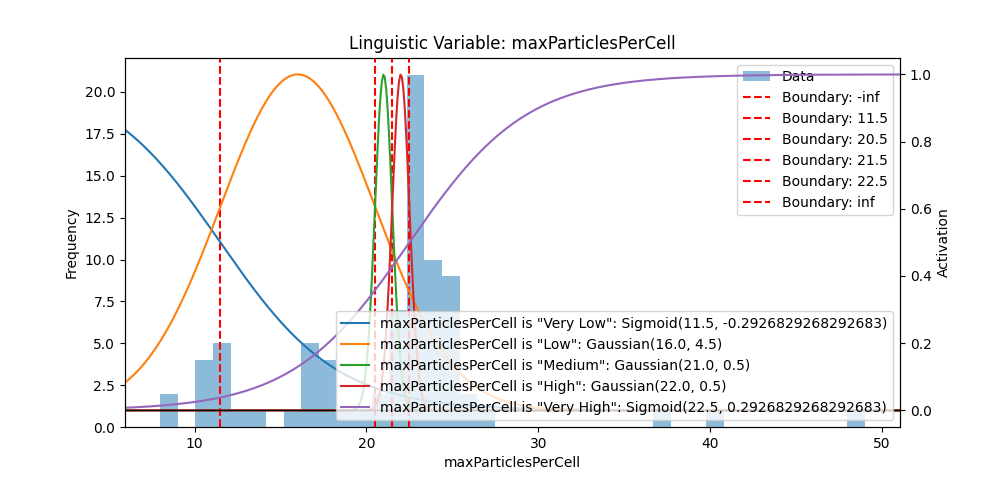

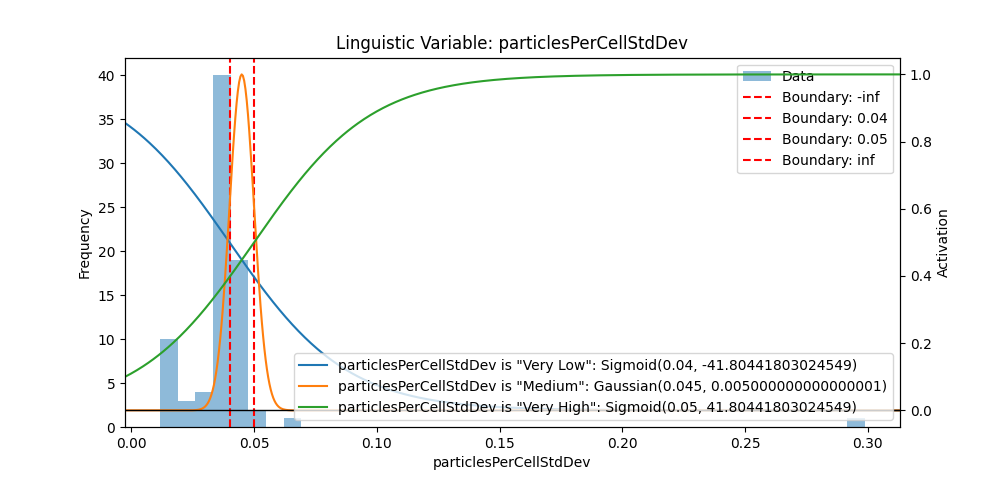

In [15]:
inputs_approach1, rules_approach1 = create_rules_approach1(
    X_train, auto_rules)

# Aproach 2

Follows https://www.sciencedirect.com/science/article/pii/S0165011406002533


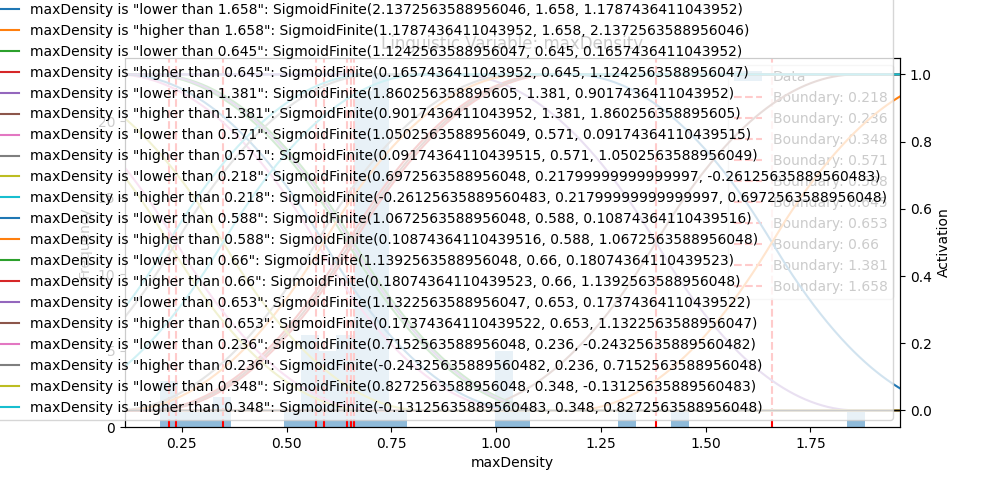

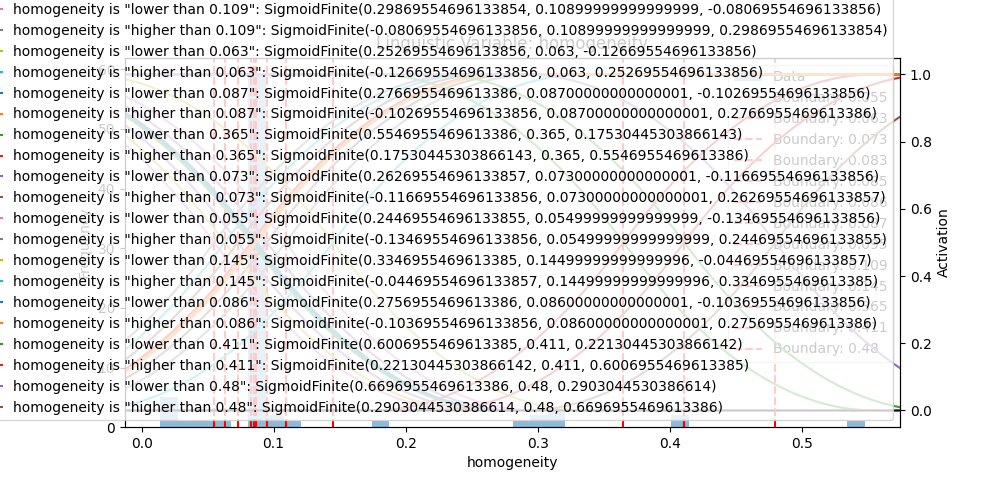

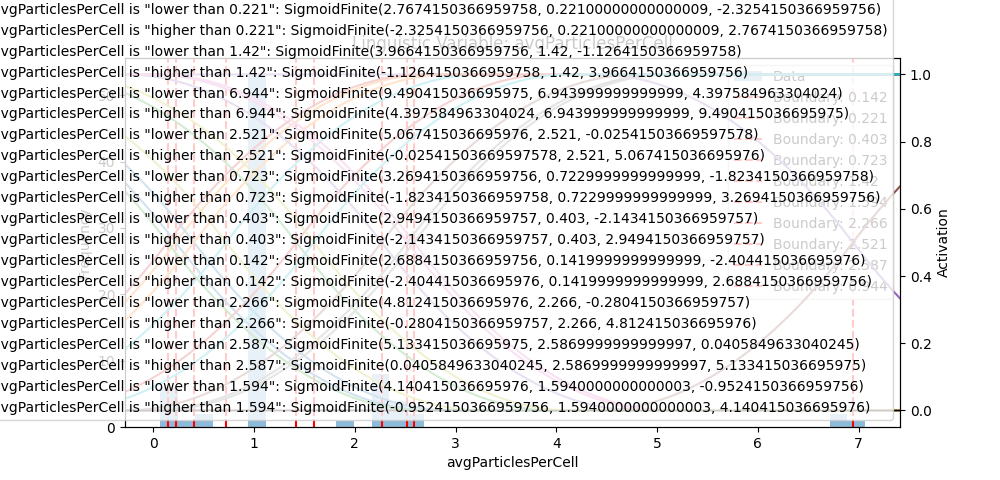

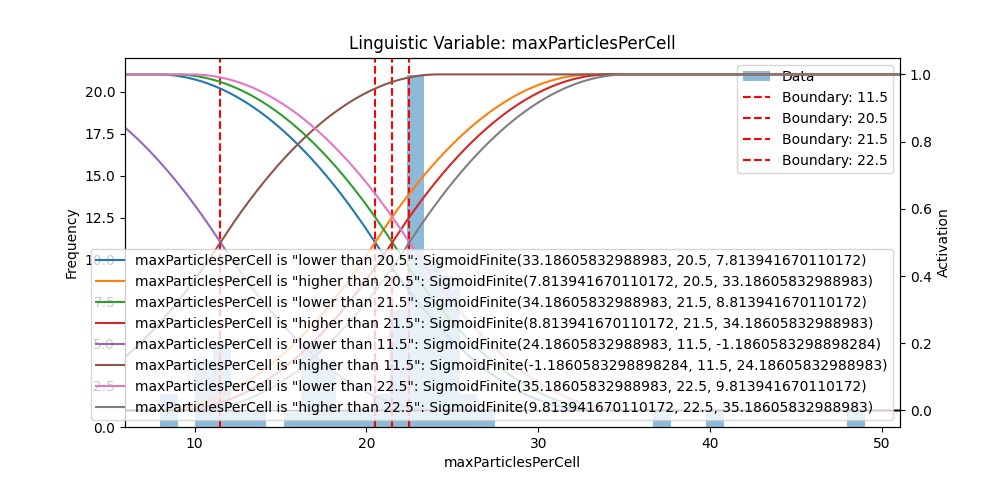

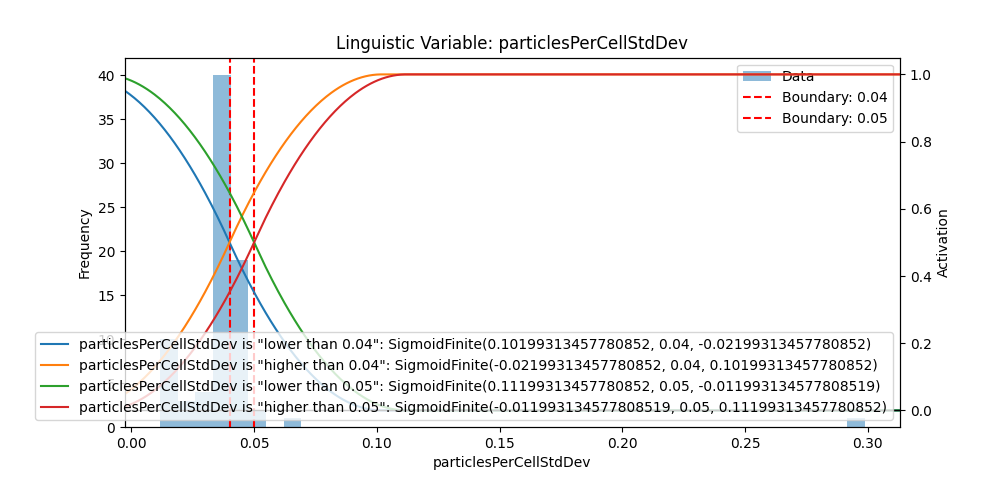

In [16]:
inputs_approach_2, rules_approach2 = create_rules_approach2(
    X_train, auto_rules)

/home/manuel/AutoPas-FuzzyTuning-Bachelor-Thesis/data-analysis/wsl-examples-pause/../rule_extraction.py:504: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots(1, 1)


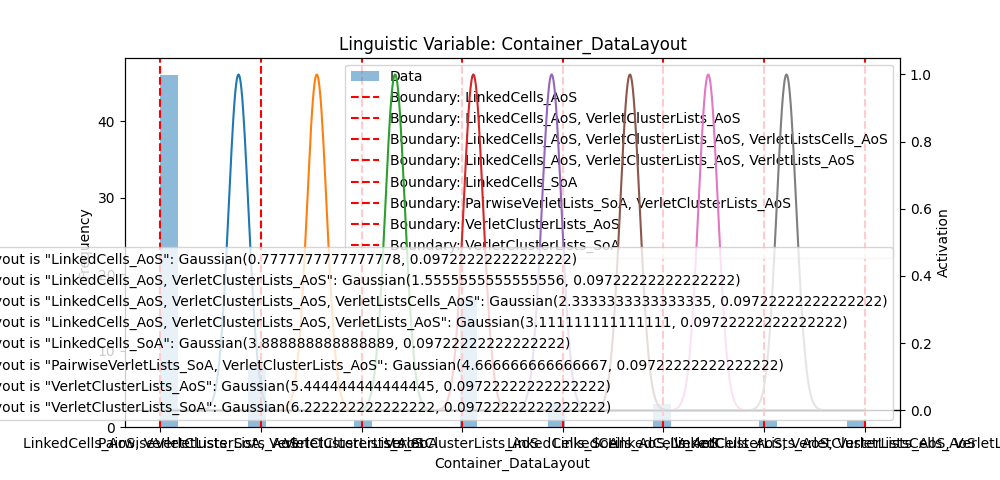

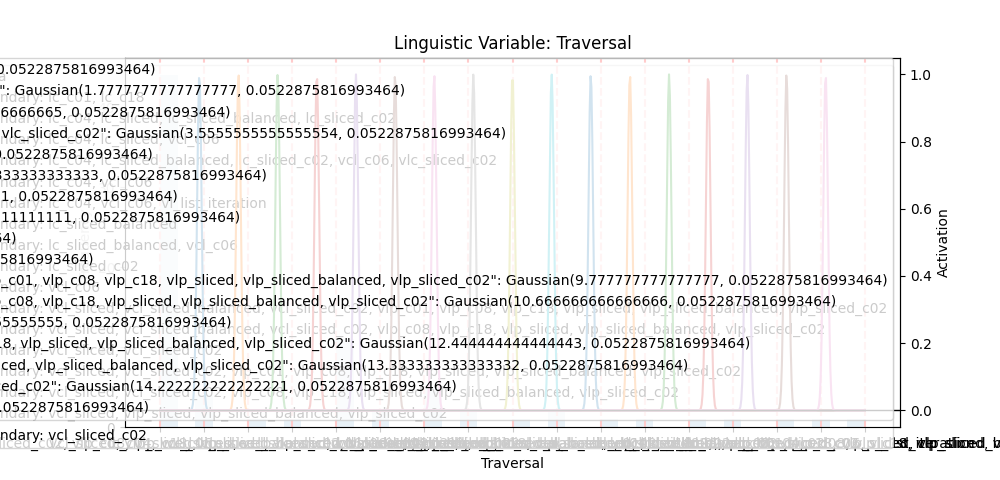

Error in callback <function flush_figures at 0x7ff5c66454e0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [17]:
outputRangeMembershipFunctions = create_output_membership_functions(y_train)

# Save all the data


In [ ]:
save_linguistic_variables(inputs_approach1, "approach1/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach1/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach1, "approach1/fuzzy-rules.txt")


save_linguistic_variables(inputs_approach_2, "approach2/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach2/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach2, "approach2/fuzzy-rules.txt")

FuzzyVariable: domain: "maxDensity" range: (-0.2810033588956048, 2.358903358895605)
	"Extremely Low": Sigmoid(0.218, -92.30769230769232)
	"Very Low": Gaussian(0.283, 0.06499999999999999)
	"Low": Gaussian(0.45949999999999996, 0.11149999999999999)
	"Medium": Gaussian(0.608, 0.03700000000000003)
	"High": Gaussian(1.013, 0.368)
	"Very High": Gaussian(1.5194999999999999, 0.13849999999999996)
	"Extremely High": Sigmoid(1.658, 43.32129963898918)

FuzzyVariable: domain: "homogeneity" range: (-0.17559954696133856, 0.7375225469613385)
	"Extremely Low": Sigmoid(0.055, -1500.0)
	"Very Low": Gaussian(0.059, 0.004)
	"Very Low 1": Gaussian(0.068, 0.0049999999999999975)
	"Low": Gaussian(0.078, 0.0050000000000000044)
	"Low 2": Gaussian(0.089, 0.005999999999999998)
	"Medium": Gaussian(0.10200000000000001, 0.006999999999999999)
	"High": Gaussian(0.127, 0.017999999999999995)
	"High 4": Gaussian(0.255, 0.11)
	"Very High": Gaussian(0.388, 0.022999999999999993)
	"Very High 5": Gaussian(0.4455, 0.0345)
	"Extr